In [1]:
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller test
from statsmodels.stats.diagnostic import acorr_ljungbox # White noise test
import statsmodels.api as sm # BIC
from statsmodels.tsa.arima.model import ARIMA # ARIMA model
from statsmodels.stats.stattools import durbin_watson # DW test
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import warnings

In [ ]:
warnings.filterwarnings("ignore")

# Data processing -> Smoothing -> Ordering -> Modeling -> Forecasting -> Evaluating

### Data processing

In [2]:
# Import data
sales_tv = pd.read_csv("/Users/Xianghao/Desktop/M5/sales_train_validation.csv")
sales_te = pd.read_csv("/Users/Xianghao/Desktop/M5/sales_train_evaluation.csv")
cal = pd.read_csv("/Users/Xianghao/Desktop/M5/calendar.csv")

In [111]:
# A bit of preprocessing and df transformation

# Dropping some columns and transposing the table to time series format
sales_te_pre = sales_te.drop(["item_id","dept_id","cat_id","store_id","state_id"], axis=1).T 
sales_te_pre = sales_te_pre.set_axis(sales_te_pre.iloc[0,:], axis="columns").drop(["id"], axis=0)

sales_tv_pre = sales_tv.drop(["item_id","dept_id","cat_id","store_id","state_id"], axis=1).T 
sales_tv_pre = sales_tv_pre.set_axis(sales_tv_pre.iloc[0,:], axis="columns").drop(["id"], axis=0)

# Setting the index of Calendar dataset to match sales dataset
cal.set_index("d", inplace=True)

# joining two dataset by index
data_evaluation = sales_te_pre.join(cal, how="left")
data_validation = sales_tv_pre.join(cal, how="left")

data_evaluation.drop(["event_name_1", "event_type_1", "event_type_2", "event_name_2", "snap_CA", "snap_TX", "snap_WI",
                "wm_yr_wk", "weekday", "wday", "month", "year"],
                axis = 1,
                inplace = True)
data_evaluation.set_index("date", inplace = True)

data_validation.drop(["event_name_1", "event_type_1", "event_type_2", "event_name_2", "snap_CA", "snap_TX", "snap_WI",
                "wm_yr_wk", "weekday", "wday", "month", "year"],
                axis = 1,
                inplace = True)
data_validation.set_index("date", inplace = True)

In [81]:
#def Splitting_validation(): #Splitting validation data  
    #train_data = data_validation.iloc[0:len(data_validation)-28]
    #test_data = data_validation.iloc[len(data_validation)-28:]
    #return train_data,test_data

In [112]:
def Splitting_evaluation(): #Splitting evaluation data
    train_data = data_evaluation.iloc[0:len(data_evaluation)-28]
    test_data = data_evaluation.iloc[len(data_evaluation)-28:]
    
    return train_data,test_data

In [113]:
# Get train data and test data
train_data,test_data = Splitting_evaluation()
row_train_data = train_data 

In [20]:
#train_data,test_data = Splitting_validation()
#row_train_data = train_data 

In [114]:
data_evaluation

,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,0,0,0,1,0,0,1,5,0,1,...,3,6,3,0,0,1,0,1,0,0
2016-05-19,3,0,2,3,0,0,0,4,0,1,...,1,4,3,1,2,0,1,0,1,2
2016-05-20,3,0,3,0,2,5,1,1,0,0,...,3,4,3,1,1,0,0,1,1,2


In [115]:
train_data

,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,1,1,1,0,1,0,1,4,0,0,...,4,1,1,0,0,0,0,1,1,0
2016-04-21,3,0,0,1,2,0,0,6,0,0,...,2,3,3,0,2,1,0,0,0,0
2016-04-22,0,0,1,3,2,2,0,3,0,2,...,0,1,6,0,3,0,0,0,3,0


In [116]:
pd.options.display.max_rows = 10
test_data

,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
date,,,,,,,,,,,,,,,,,,,,,
2016-04-25,0,0,0,0,1,0,0,19,0,0,...,0,4,2,0,0,0,0,0,1,0
2016-04-26,0,1,0,0,0,0,0,3,2,2,...,4,2,2,0,2,0,1,0,3,0
2016-04-27,0,0,1,1,2,1,0,2,6,1,...,0,0,1,0,2,0,1,1,0,0
2016-04-28,2,0,1,2,3,0,0,8,0,0,...,1,0,1,3,2,2,1,1,1,0
2016-04-29,0,0,0,4,1,0,1,8,0,0,...,2,1,1,1,2,2,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,0,0,0,1,0,0,1,5,0,1,...,3,6,3,0,0,1,0,1,0,0
2016-05-19,3,0,2,3,0,0,0,4,0,1,...,1,4,3,1,2,0,1,0,1,2
2016-05-20,3,0,3,0,2,5,1,1,0,0,...,3,4,3,1,1,0,0,1,1,2


### Smoothing and Ordering

In [117]:
# First difference
def stationarity(timeseries): 
    diff1 = timeseries.diff(1).dropna() # First difference for stationarity
    
    return diff1

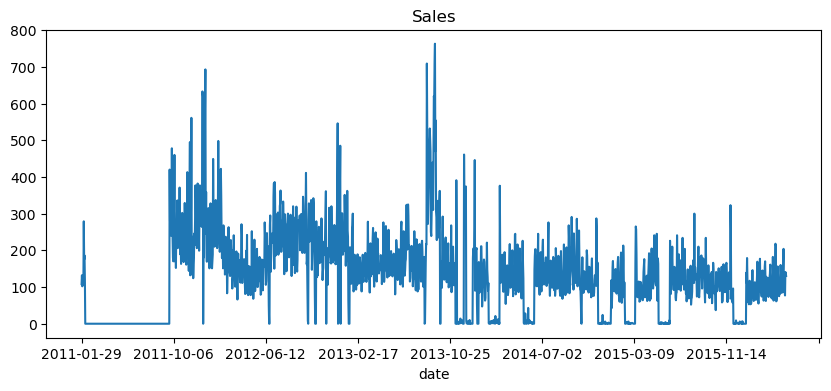

In [188]:
train_data_single = train_data.loc[:, 'FOODS_3_090_CA_3_evaluation']
train_data_single.plot(figsize = (10,4))
row_train_data_single = train_data_single
plt.title("Sales")

plt.show()

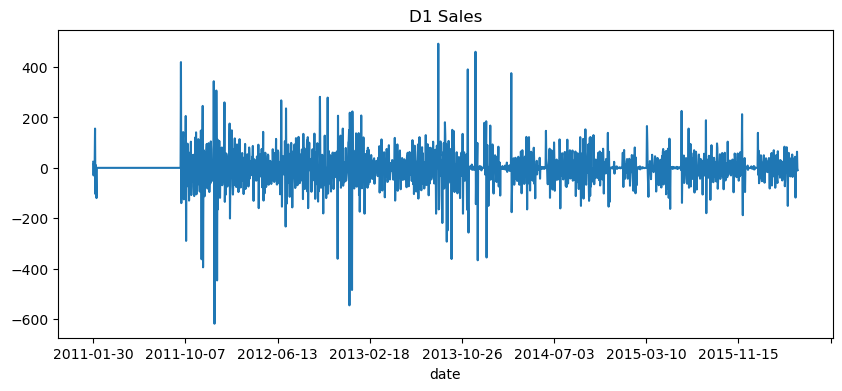

In [119]:
diff1 = stationarity(train_data_single)

diff1.plot(figsize = (10,4))
plt.title("D1 Sales")

plt.show()

In [120]:
## Augmented Dickey-Fuller test
# Stationarity test for high order of autocorrelations
def ADF_test(timeseries): ## Stationarity test for high order of autocorrelations
    adftest = adfuller(np.array(timeseries), autolag='AIC')
    if adftest[0] < adftest[4]["5%"] and adftest[1] < 10**(-3): 
    # adftest[0] = ADF results, 
    # adftest[4] = Dickey-Fuller critical values: 1%: -3.43, 5%: -2.86, 10%: -2.57
    # adftest[1] = P-value, 
    
        #print("Stationarity, we can continue")
        return True # Stationarity
        
    else:
        #print("Non-Stationarity")
        return False # Non-Stationarity
    

def random_test(timeseries) : # White noise test
    p_value = acorr_ljungbox(timeseries, lags=1).iloc[0,1] 
    if p_value < 0.05: 
        #print("Not White noise, we can continue")
        return  True
    else:
        #print("White noise")
        return False


In [121]:
ADF_test(train_data_single)

True

In [122]:
random_test(train_data_single)

True

In [123]:
#Time series ordering ARIMA(p,?,q)
if ADF_test(train_data_single) == 1 and random_test(train_data_single) == 1 :
    dif = 0
elif ADF_test(stationarity(train_data_single)) == 1 and random_test(stationarity(train_data_single)) == 1 :
    train_data_single = train_data_single.diff(1)
    dif = 1
else :
    train_data_single = train_data_single.diff(2)
    dif = 2

print(dif)

0


In [124]:
#Time series ordering ARIMA(?,d,?)
def detetminante_order_BIC(timeseries): #BIC

    BIC = sm.tsa.arma_order_select_ic(timeseries,max_ar=4,\
           max_ma=2,ic='bic')['bic_min_order']
    return BIC


In [125]:
bic = detetminante_order_BIC(train_data_single)
print(bic)

(3, 1)


### Modeling

In [181]:
def ARIMA_model(train_data, order):
    arima = ARIMA(train_data, order=(bic[0],dif,bic[1])).fit() 

    #print(arima.forecast(28))
    print(arima.summary())
    in_sample_pred = arima.predict()
    out_sample_pred = arima.predict(start=len(train_data),end = len(train_data)+27, \
                              dynamic=True)
    #forecast = arima.forecast(28)
    #print('arima', arima)
    #print('in_sample_pred', in_sample_pred )
    #print('out_sample_pred', out_sample_pred )
    

    return arima, in_sample_pred, out_sample_pred

In [182]:
arima, in_sample_pred, out_sample_pred = ARIMA_model(train_data_single.astype(np.float32), order=(bic[0],dif,bic[1]))

                                    SARIMAX Results                                    
Dep. Variable:     FOODS_3_090_CA_3_evaluation   No. Observations:                 1913
Model:                          ARIMA(3, 0, 1)   Log Likelihood              -10638.529
Date:                         Thu, 29 Dec 2022   AIC                          21289.059
Time:                                 16:39:29   BIC                          21322.397
Sample:                             01-29-2011   HQIC                         21301.328
                                  - 04-24-2016                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        130.9444     28.607      4.577      0.000      74.877     187.012
ar.L1          1.4465      0.024     60.264      0.000     

### Evaluating

In [166]:
def evaluate_model(model,train_data,predict_data):
    
    resid = model.resid  # Residuals
    # Use the D-W test to test the autocorrelation of the residuals
    return durbin_watson(resid.values)

In [167]:
dw_test = evaluate_model(arima, train_data_single, in_sample_pred)
print(dw_test)
if dw_test < 2.1 and dw_test >1.9 :
    print('Good')

2.009514745395253
Good


In [196]:
# export data
#dataset_name = out_sample_pred.reset_index(drop=True)

In [195]:
#dataset_name.to_csv("eval_preds.csv", index=True)

In [132]:
def draw_picture(row_train_data,out_sample_pred,test_data): 

    x = []
    for i in range(28):
        x.append(i+1)
    x = np.array(x)

    y1 = np.array(test_data)
    y2 = np.array(out_sample_pred[1:])
    
    plt.plot(x,y1,color='blue')
    plt.plot(x,y2,color='red')
    plt.show()

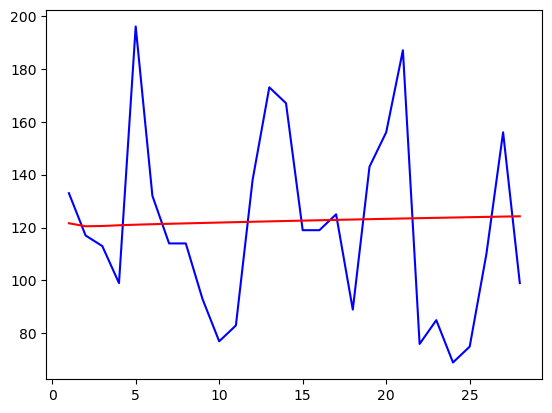

In [133]:
draw_picture(row_train_data_single,out_sample_pred,test_data.loc[:, 'FOODS_3_090_CA_3_evaluation'])